## Reinforcement Learning

We first write a function to create a data frame including stock price data for the past 5 years including open, close, low, and high prices. We also add columns for the difference between open and close prices, the difference between high and low prices, and whether that month is the end of a quarter to predict the buy or not for investors.

In [1]:
import keras
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
import tensorflow as tf

import yfinance as yf
import math
import numpy as np
import pandas as pd
import random
from collections import deque

In [2]:
def create_price_df(ticker):
    """
    ticker: the chosen company stock

    Return: returns a dataframe of a company's stock price data and features we want to use in machine learning model
    """
    price_df = price_df=yf.download(tickers = ticker, period = "5y", interval = "1d",
    prepost = False, repair = True)
    price_df["date"]=price_df.index
    price_df.reset_index()
    price_df["Date"] = price_df["date"].transform(lambda x: x.date())
    price_df["Date"] = price_df["Date"].transform(lambda x: str(x))
    price_df = price_df.drop(['date'],axis=1)
    splitted=price_df['Date'].str.split('-',expand = True)
    price_df['day'] = splitted[2].astype('int')
    price_df['month'] = splitted[1].astype('int')
    price_df['year'] = splitted[0].astype('int')
    price_df['is_quarter_end']=np.where(price_df['month']%3 == 0,1,0)
    price_df['open-close']  = price_df['Open'] - price_df['Close']
    price_df['low-high']  = price_df['Low'] - price_df['High']
    price_df['target'] = np.where(price_df['Close'].shift(-1) > price_df['Close'], 1, 0)
    #if the close price of the previous day is higher than today's close price, then the investor will buy the stock
    return price_df

In [3]:
# ticker is basically a abbreviation for a company stock.
ticker=input("Please enter your ticker: ")
price_df = create_price_df(ticker = ticker)

[*********************100%%**********************]  1 of 1 completed


In [4]:
price_df

,Open,High,Low,Close,Adj Close,Volume,Repaired?,Date,day,month,year,is_quarter_end,open-close,low-high,target
Date,,,,,,,,,,,,,,,
2019-03-12,19.099333,19.204666,18.737333,18.890667,18.890667,112561500,False,2019-03-12,12,3,2019,1,0.208666,-0.467333,1
2019-03-13,18.926666,19.466000,18.846666,19.264000,19.264000,102670500,False,2019-03-13,13,3,2019,1,-0.337334,-0.619333,1
2019-03-14,19.496668,19.692667,19.219334,19.330667,19.330667,106551000,False,2019-03-14,14,3,2019,1,0.166000,-0.473333,0
2019-03-15,18.900667,18.914667,18.293333,18.362000,18.362000,221782500,False,2019-03-15,15,3,2019,1,0.538668,-0.621334,0
2019-03-18,18.400000,18.536667,17.820000,17.966000,17.966000,154215000,False,2019-03-18,18,3,2019,1,0.434000,-0.716667,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-06,179.990005,181.580002,173.699997,176.539993,176.539993,107920900,False,2024-03-06,6,3,2024,1,3.450012,-7.880005,1
2024-03-07,174.350006,180.039993,173.699997,178.649994,178.649994,102129000,False,2024-03-07,7,3,2024,1,-4.299988,-6.339996,0
2024-03-08,181.500000,182.729996,174.699997,175.339996,175.339996,85315300,False,2024-03-08,8,3,2024,1,6.160004,-8.029999,1


The code sets up a reinforcement learning agent with a neural network model that learns to make decisions (buying, selling, or sitting) in a stock trading environment. The agent learns from its experiences using the Q-learning algorithm and improves its performance over time through repeated interactions with the environment.

The act method determines the agent's action based on the current state. The neural network model predicts the Q-values for the current state. These predicted Q-values correspond to the estimated future rewards for each possible action the agent can take. The agent then chooses the action with the highest predicted Q-value, unless it is in evaluation mode (is_eval=True) or randomly selected due to exploration.

The expReplay method implements experience replay. It samples a batch of experiences from the memory and updates the model's weights based on the Bellman equation, which estimates the optimal action-value function (Q-value).

In [5]:
# Agent class
class Agent:
    def __init__(self, state_size, is_eval=False, model_name=""):
        """Initialize Agent class:
        Define static variables like gamma, epsilon, epsilon_min, and epsilon_decay to
          manage the trade-off between exploration and exploitation in the decision-making process.
        Gamma (discount factor) influences how future rewards are valued.
        Epsilon controls the rate of exploration versus exploitation,
          with epsilon_min and epsilon_decay dictating the minimum exploration rate and how quickly exploration decreases, respectively.
        These parameters are crucial for the agent's strategy in buying and selling stocks,
          ensuring a balance between exploiting known strategies and exploring new possibilities."""

        self.state_size = state_size
          # length of the historical sequence of stock prices that the agent uses as its input state size, measured in trading days
        self.action_size = 3
          # 3 actions: sit, buy, sell
        self.memory = deque(maxlen=1000)
          # internal memory with maximum length 1000, used for experience replay;
          # allows the agent to learn from past experiences.
        self.inventory = []
          # keep track of the stocks currently held by the agent
          # A "buy" action adds the stock to the inventory, while a "sell" action removes it.
        self.model_name = model_name
          # name of the model
        self.is_eval = is_eval
          # evaluation flag
        self.gamma = 0.95
          # discount rate for the next state; determines the present value of future rewards;
          # As γ is closer to 0, the agent prioritizes immediate rewards more heavily, focusing on short-term gains;
          # As γ approaches 1, the agent places greater value on future rewards, encouraging strategies with more
          # pay-off in the long run.
        self.epsilon = 1.0
          # exploration rate; used to implement the ϵ-greedy strategy, where the agent randomly explores the
          # environment with a probability of ϵ and exploits its current knowledge with a probability of 1−ϵ;
          # If epsilon is set to 0, we never explore but always exploit the knowledge we already have.
          # On the contrary, a higher value of ϵ (closer to 1) is used to encourage exploration of the environment.
        self.epsilon_min = 0.01
          # minimum exploration probability; sets the lower bound of ϵ;
          # ensure the agent continues to explore the environment to a certain extent even after extensive training.
        self.epsilon_decay = 0.995
          # exponential decay rate for exploration prob; controls the rate at which ϵ decreases over time;
          # gradually shifting the agent's strategy from exploration towards exploitation.
        self.model = load_model(model_name) if is_eval else self._model()
          # load model if is_eval is true, else create a new model

    def _model(self):
        """Neural Network Model"""
        # # create a neural network model with 3 hidden layers, to predict the reward value of actions.
        # model = Sequential()
        # model.add(Dense(units=64, input_dim=self.state_size, activation="relu"))
        # model.add(Dense(units=32, activation="relu"))
        # model.add(Dense(units=8, activation="relu"))
        # model.add(Dense(self.action_size, activation="linear"))
        # model.compile(loss="mse", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
        # # mean squared error loss, adam optimizer with learning rate of 0.001
        
        model = tf.keras.Sequential([
            # Input layer: No need to explicitly set an input layer. The input shape will be determined in the first Dense layer.
            # First Dense layer with ReLU activation. The `input_dim` parameter specifies the size of the input layer.
            tf.keras.layers.Dense(units=16, activation='relu', input_dim=self.state_size),

            # Second Dense layer with ReLU activation.
            tf.keras.layers.Dense(units=8, activation='relu'),

            # Output layer with linear activation, since we're predicting Q-values which are continuous.
            tf.keras.layers.Dense(units=self.action_size, activation='linear')
        ])

        # Compile the model. For a Q-learning model, we typically use the Mean Squared Error (MSE) loss and an optimizer like Adam.
        model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
                      loss='mse',
                      metrics=['accuracy'])  # Metrics are optional and may not be very meaningful in this context.
        return model

    def act(self, state):
        """Agent will act upon the current state:
        defines how the agent chooses an action based on the current state it is in."""
        # Exploration:
        if not self.is_eval and random.random()<= self.epsilon:
            # Check if the agent is not in evaluation mode and
            # if a randomly generated number between 0 and 1 is within the boundary.
            # If both conditions are met, the agent is in the exploration phase,
            # and an action is chosen randomly from the available action space.
            return random.randrange(self.action_size)
        # Exploitation:
            # If the agent decides not to explore, it enters the exploitation phase;
            # it chooses the action that it believes will yield the highest reward based on current knowledge.
        options = self.model.predict(state)
            # given the current state, use the agent's NN model to predict the reward value of each possible action.
        return np.argmax(options[0])
            # select the action with the highest predicted reward.

    def expReplay(self, batch_size):
        """Experience Replay
        Involves storing past experiences (state, action, reward, next_state, done) in a memory
        buffer and later randomly sampling a mini-batch of these experiences to train the model."""

        minibatch = random.sample(self.memory, batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        targets = rewards + self.gamma*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        ind = np.array([i for i in range(batch_size)])
        targets_full[[ind], [actions]] = targets

        self.model.fit(states, targets_full, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [6]:
def formatPrice(n):
    """Format price"""
    # format price as $x.xx
    return("-$ " if n<0 else "$ ")+"{0:.2f}".format(abs(n))

def sigmoid(x):
    """Sigmoid function"""
    # sigmoid "squashing" function to interval [0,1], for normalization purpose
    return 1/(1+math.exp(-x))

def getState(data, t, n):
    """Get state
    data: A list or array containing the historical data points (e.g., stock prices).
    t: The current timestep for which the state is being generated.
    n: The window size, indicating how many timesteps back the state should consider."""
    d = t - n + 1
      # Calculate the starting index of the data block that will be used to generate the state.
      # d identifies the earliest timestep in the window.

    block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1]
      # Extract the relevant block of data for the state.
      # If d is non-negative, it directly slices the data array from d to t, inclusive.
      # Else(the window extends beyond the start of the available data), it pads the
      # beginning of the block with the value at data[0]. The number of times data[0] is
      # repeated corresponds to -d, ensuring the resulting block has a length of n.

    res = []
      # list to store the price changes within the window.
    for i in range(n - 1):
        res.append(sigmoid(block[i + 1] - block[i]))
        # calculate price change between successive timesteps and apply the sigmoid function to each change.

    # return array of price changes
    return np.array([res])

The code below performs the training loop for the reinforcement learning agent in the stock trading environment. It interacts with the environment, executes actions, and updates the agent's neural network model based on the observed rewards.

One thing to note is the agent's memory. The agent's memory is used for experience replay, which is a technique in reinforcement learning that helps improve the agent's learning efficiency and stability. During the training process, the agent samples a batch of experiences from its memory and uses them to update its model through a process called experience replay. This helps the agent learn from a diverse set of experiences and reduces the correlation between consecutive samples.

In [7]:
import sys
# window_size = input()
# episode_count = input()
window_size = 6
episode_count = 20

window_size = int(window_size)
  # Window size represents the length of historical sequence of stock prices that the agent uses as its input state.
  # This allows the agent to consider patterns over a specified number of previous time steps when making decisions.
  # By setting a larger window size, the agent can capture more historical price patterns and possibly make more informed decisions.
episode_count = int(episode_count)
  # The number of episodes for which the agent will be trained.
  # Each episode represents a complete sequence of decisions (trading actions) from start to finish based on the data.

agent = Agent(window_size)
  # Initialize agent
  # Recall that def __init__(self, state_size, is_eval=False, model_name="")

data=list(price_df['Close'][0:1000])
  # Get the stock data
  # specifically the closing prices, which the agent uses to learn trading strategies.

l = len(data) - 1  # data length
batch_size = 32    # batch size

# Initialize episode information list
episode_info_list = []
scores = []
# Training Loop:
for i_episode in range(episode_count+1):
    print("Episode " + str(i_episode+1) + "/" + str(episode_count))
    # The outer loop iterates through each episode, and within each episode:
    state = getState(data, 0, window_size + 1)
      # Initialize state using getState defined above.
    total_profit = 0
      # Initialize total profit: track the financial outcome of the trading strategy throughout the episode.
    agent.inventory = []
      # Initialize inventory: track prices of stocks the agent has bought and not yet sold, representing the agent's current holdings.
    total_buy_actions = 0
    total_sell_actions = 0

    for t in range(l):
        action = agent.act(state)
          # Action Selection: agent decides whether to buy, sell, or hold based on the current state.
          # Decision made using the agent.act(state) method, which implements an ε-greedy policy for exploration and exploitation.

        # Handling Actions:
          # Sit/Hold
        next_state = getState(data, t + 1, window_size + 1)
            # Compute the next_state using historical price data up to time t + 1 within a window size, allowing the agent to observe the outcome of its action.
        reward = 0
            # Initialize reward for the current action as 0.

          # Buy
            # If the agent decides to buy, add shares to its inventory.
        if action == 1:
            agent.inventory.append(data[t])
            total_buy_actions += 1
            print("Buy: " + formatPrice(data[t]))

          # Sell
            # If the agent decides to sell and has shares in its inventory,
            # it sells the oldest share (FIFO - First In, First Out),
            # calculates the profit from the sale, and updates the total profit.
            # The reward is set as the profit from this transaction, ensuring the agent is incentivized to make profitable trades.
        elif action == 2 and len(agent.inventory) > 0: # sell
            bought_price = window_size_price = agent.inventory.pop(0)
            # reward = max(data[t] - bought_price, 0)
            reward = data[t] - bought_price
            total_profit += data[t] - bought_price
            total_sell_actions += 1
            print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

        # Update Agent's Memory:
          # Check if the current timestep is the last one in the episode, setting done to True if so.
        done = True if t == l - 1 else False
          # Store experience (current state, action taken, reward received, next_state, and whether the
          # episode is done) in the agent's memory for future learning.
        agent.memory.append((state, action, reward, next_state, done))
          # Update the current state to the next state for the next timestep.
        state = next_state

        # Print the total profit if one episode is finished.
        if done:
            # Append episode information
            episode_info_list.append({
                    'Episode': i_episode,
                    'Total_Buy_Actions': total_buy_actions,
                    'Total_Sell_Actions': total_sell_actions,
                    'Total_profit': total_profit
                })

            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("--------------------------------")
      
        # Learning From Experience:
          # Once the agent has accumulated enough experiences in its memory (more than batch_size),
          # it samples a mini-batch of experiences to learn from, adjusting its policy based on the outcomes of past actions.
        if len(agent.memory) > batch_size:
            agent.expReplay(batch_size) # mini-batch size instead of batch size
    scores.append(total_profit)
    # Periodically (every 2 episodes here), the agent's model is saved for later use or evaluation.
    # Useful for tracking progress over time or resuming training later.
    if i_episode % 2 == 0:
        agent.model.save(str(i_episode))

    # Display the episode information DataFrame
episode_df = pd.DataFrame(episode_info_list)
print(episode_df)


Episode 1/20
Buy: $ 19.26
Sell: $ 18.36 | Profit: -$ 0.90
Buy: $ 17.83
Sell: $ 18.24 | Profit: $ 0.41
Buy: $ 18.27
Sell: $ 17.85 | Profit: -$ 0.42
Buy: $ 17.85
Sell: $ 18.33 | Profit: $ 0.48
Buy: $ 18.21
Buy: $ 18.40
Buy: $ 17.76
Buy: $ 18.08
Sell: $ 18.22 | Profit: $ 0.00
Sell: $ 17.52 | Profit: -$ 0.89
Sell: $ 17.24 | Profit: -$ 0.51
Buy: $ 16.51
Buy: $ 15.68
Sell: $ 16.10 | Profit: -$ 1.98
Buy: $ 15.91
Sell: $ 16.27 | Profit: -$ 0.24
Sell: $ 17.00 | Profit: $ 1.33
Buy: $ 17.02
Sell: $ 16.47 | Profit: $ 0.56
Buy: $ 16.32
Sell: $ 16.13 | Profit: -$ 0.89
Sell: $ 15.13 | Profit: -$ 1.19
1/1 [==============================] - 0s 9ms/step
Buy: $ 12.58
Sell: $ 12.66 | Profit: $ 0.08
Buy: $ 12.55
Sell: $ 12.34 | Profit: -$ 0.20
Buy: $ 13.73
Buy: $ 14.19
Sell: $ 14.33 | Profit: $ 0.60
Buy: $ 15.00
Buy: $ 14.98
Buy: $ 15.10
1/1 [==============================] - 0s 9ms/step
Sell: $ 14.79 | Profit: $ 0.60
Buy: $ 14.65
Sell: $ 14.62 | Profit: -$ 0.38
Sell: $ 14.86 | Profit: -$ 0.13
1/1 [=======

INFO:tensorflow:Assets written to: 0/assets


Episode 2/20
1/1 [==============================] - 0s 9ms/step
Buy: $ 16.04
1/1 [==============================] - 0s 9ms/step
Sell: $ 16.08 | Profit: $ 0.04
1/1 [==============================] - 0s 9ms/step
Buy: $ 53.33
1/1 [==============================] - 0s 9ms/step
Buy: $ 51.92
1/1 [==============================] - 0s 9ms/step
Buy: $ 45.27
1/1 [==============================] - 0s 9ms/step
Buy: $ 44.53
1/1 [==============================] - 0s 10ms/step
Sell: $ 46.90 | Profit: -$ 6.43
1/1 [==============================] - 0s 9ms/step
Buy: $ 40.53
1/1 [==============================] - 0s 9ms/step
Sell: $ 43.02 | Profit: -$ 8.90
1/1 [==============================] - 0s 10ms/step
Buy: $ 37.37
1/1 [==============================] - 0s 9ms/step
Buy: $ 29.67
1/1 [==============================] - 0s 11ms/step
Buy: $ 28.68
1/1 [==============================] - 0s 10ms/step
Sell: $ 35.95 | Profit: -$ 9.32
1/1 [==============================] - 0s 9ms/step
Buy: $ 33.48
1/1 [=======

INFO:tensorflow:Assets written to: 2/assets


Episode 4/20
1/1 [==============================] - 0s 9ms/step
Buy: $ 51.42
1/1 [==============================] - 0s 9ms/step
Sell: $ 51.15 | Profit: -$ 0.27
1/1 [==============================] - 0s 9ms/step
Buy: $ 45.78
1/1 [==============================] - 0s 9ms/step
Sell: $ 51.27 | Profit: $ 5.49
1/1 [==============================] - 0s 8ms/step
Buy: $ 281.67
1/1 [==============================] - 0s 8ms/step
Sell: $ 282.21 | Profit: $ 0.55
1/1 [==============================] - 0s 8ms/step
Buy: $ 294.36
1/1 [==============================] - 0s 9ms/step
Buy: $ 287.81
1/1 [==============================] - 0s 9ms/step
Sell: $ 266.05 | Profit: -$ 28.31
1/1 [==============================] - 0s 11ms/step
Sell: $ 230.35 | Profit: -$ 57.46
1/1 [==============================] - 0s 10ms/step
Buy: $ 223.66
1/1 [==============================] - 0s 8ms/step
Sell: $ 246.28 | Profit: $ 22.63
1/1 [==============================] - 0s 8ms/step
Buy: $ 238.21
1/1 [=========================

INFO:tensorflow:Assets written to: 4/assets


Episode 6/20
1/1 [==============================] - 0s 8ms/step
Buy: $ 17.97
1/1 [==============================] - 0s 9ms/step
Buy: $ 17.83
1/1 [==============================] - 0s 8ms/step
Buy: $ 18.24
1/1 [==============================] - 0s 9ms/step
Sell: $ 18.27 | Profit: $ 0.30
1/1 [==============================] - 0s 9ms/step
Sell: $ 17.64 | Profit: -$ 0.20
1/1 [==============================] - 0s 8ms/step
Sell: $ 17.36 | Profit: -$ 0.88
1/1 [==============================] - 0s 8ms/step
Buy: $ 17.85
1/1 [==============================] - 0s 8ms/step
Sell: $ 18.32 | Profit: $ 0.47
1/1 [==============================] - 0s 8ms/step
Buy: $ 18.15
1/1 [==============================] - 0s 8ms/step
Sell: $ 18.40 | Profit: $ 0.25
1/1 [==============================] - 0s 8ms/step
Buy: $ 17.59
1/1 [==============================] - 0s 9ms/step
Sell: $ 17.24 | Profit: -$ 0.35
1/1 [==============================] - 0s 8ms/step
Buy: $ 15.91
1/1 [==============================] - 0s 9m

INFO:tensorflow:Assets written to: 6/assets


Episode 8/20
1/1 [==============================] - 0s 9ms/step
Buy: $ 22.41
1/1 [==============================] - 0s 9ms/step
Sell: $ 22.20 | Profit: -$ 0.21
1/1 [==============================] - 0s 10ms/step
Buy: $ 33.67
1/1 [==============================] - 0s 15ms/step
Sell: $ 35.95 | Profit: $ 2.28
1/1 [==============================] - 0s 9ms/step
Buy: $ 57.63
1/1 [==============================] - 0s 9ms/step
Sell: $ 62.71 | Profit: $ 5.09
1/1 [==============================] - 0s 9ms/step
Buy: $ 339.01
1/1 [==============================] - 0s 9ms/step
Sell: $ 355.67 | Profit: $ 16.66
1/1 [==============================] - 0s 9ms/step
Buy: $ 310.42
1/1 [==============================] - 0s 10ms/step
Buy: $ 301.52
1/1 [==============================] - 0s 9ms/step
Buy: $ 307.80
1/1 [==============================] - 0s 9ms/step
Buy: $ 292.12
1/1 [==============================] - 0s 10ms/step
Sell: $ 290.14 | Profit: -$ 20.27
1/1 [==============================] - 0s 9ms/step

INFO:tensorflow:Assets written to: 8/assets


Episode 10/20
1/1 [==============================] - 0s 14ms/step
Buy: $ 14.90
1/1 [==============================] - 0s 12ms/step
Buy: $ 15.54
1/1 [==============================] - 0s 11ms/step
Buy: $ 110.05
1/1 [==============================] - 0s 11ms/step
Buy: $ 122.38
1/1 [==============================] - 0s 11ms/step
Buy: $ 166.42
1/1 [==============================] - 0s 12ms/step
Sell: $ 231.67 | Profit: $ 216.77
1/1 [==============================] - 0s 11ms/step
Buy: $ 284.90
1/1 [==============================] - 0s 12ms/step
Buy: $ 233.20
1/1 [==============================] - 0s 10ms/step
Buy: $ 222.64
1/1 [==============================] - 0s 10ms/step
Buy: $ 254.11
1/1 [==============================] - 0s 10ms/step
Buy: $ 246.07
1/1 [==============================] - 0s 10ms/step
Buy: $ 201.71
1/1 [==============================] - 0s 10ms/step
Buy: $ 201.20
1/1 [==============================] - 0s 11ms/step
Buy: $ 207.77
1/1 [==============================] - 0s 10

INFO:tensorflow:Assets written to: 10/assets


Episode 12/20
1/1 [==============================] - 0s 9ms/step
Buy: $ 18.32
1/1 [==============================] - 0s 9ms/step
Sell: $ 18.57 | Profit: $ 0.25
1/1 [==============================] - 0s 9ms/step
Buy: $ 50.26
1/1 [==============================] - 0s 9ms/step
Buy: $ 64.86
1/1 [==============================] - 0s 9ms/step
Sell: $ 66.73 | Profit: $ 16.47
1/1 [==============================] - 0s 9ms/step
Sell: $ 80.58 | Profit: $ 15.72
1/1 [==============================] - 0s 9ms/step
Buy: $ 99.80
1/1 [==============================] - 0s 9ms/step
Buy: $ 94.47
1/1 [==============================] - 0s 8ms/step
Buy: $ 99.00
1/1 [==============================] - 0s 9ms/step
Buy: $ 99.31
1/1 [==============================] - 0s 9ms/step
Buy: $ 110.05
1/1 [==============================] - 0s 9ms/step
Sell: $ 122.38 | Profit: $ 22.57
1/1 [==============================] - 0s 9ms/step
Buy: $ 125.81
1/1 [==============================] - 0s 9ms/step
Sell: $ 125.24 | Profit: 

INFO:tensorflow:Assets written to: 12/assets


Episode 14/20
1/1 [==============================] - 0s 10ms/step
Buy: $ 18.89
1/1 [==============================] - 0s 8ms/step
Buy: $ 19.26
1/1 [==============================] - 0s 9ms/step
Buy: $ 19.33
1/1 [==============================] - 0s 9ms/step
Buy: $ 18.36
1/1 [==============================] - 0s 9ms/step
Buy: $ 17.97
1/1 [==============================] - 0s 8ms/step
Buy: $ 17.83
1/1 [==============================] - 0s 8ms/step
Buy: $ 18.24
Buy: $ 18.27
1/1 [==============================] - 0s 9ms/step
Buy: $ 17.64
1/1 [==============================] - 0s 9ms/step
Buy: $ 17.36
1/1 [==============================] - 0s 9ms/step
Buy: $ 17.85
1/1 [==============================] - 0s 9ms/step
Buy: $ 18.32
1/1 [==============================] - 0s 8ms/step
Buy: $ 18.57
1/1 [==============================] - 0s 8ms/step
Buy: $ 18.66
1/1 [==============================] - 0s 9ms/step
Buy: $ 19.28
1/1 [==============================] - 0s 9ms/step
Buy: $ 19.06
1/1 [=======

INFO:tensorflow:Assets written to: 14/assets


Episode 16/20
1/1 [==============================] - 0s 9ms/step
Buy: $ 15.49
1/1 [==============================] - 0s 9ms/step
Sell: $ 16.39 | Profit: $ 0.90
1/1 [==============================] - 0s 9ms/step
Buy: $ 22.64
1/1 [==============================] - 0s 8ms/step
Sell: $ 23.51 | Profit: $ 0.88
1/1 [==============================] - 0s 9ms/step
Buy: $ 210.09
1/1 [==============================] - 0s 9ms/step
Buy: $ 243.13
1/1 [==============================] - 0s 9ms/step
Buy: $ 195.59
1/1 [==============================] - 0s 9ms/step
Buy: $ 379.02
1/1 [==============================] - 0s 9ms/step
Buy: $ 385.62
1/1 [==============================] - 0s 9ms/step
Buy: $ 365.00
1/1 [==============================] - 0s 9ms/step
Buy: $ 334.60
1/1 [==============================] - 0s 9ms/step
Buy: $ 339.01
1/1 [==============================] - 0s 9ms/step
Buy: $ 355.67
1/1 [==============================] - 0s 9ms/step
Buy: $ 364.65
1/1 [==============================] - 0s 9m

INFO:tensorflow:Assets written to: 16/assets


Episode 18/20
1/1 [==============================] - 0s 9ms/step
Buy: $ 99.31
1/1 [==============================] - 0s 8ms/step
Buy: $ 122.09
1/1 [==============================] - 0s 9ms/step
Buy: $ 141.93
1/1 [==============================] - 0s 9ms/step
Buy: $ 140.21
1/1 [==============================] - 0s 9ms/step
Buy: $ 136.17
1/1 [==============================] - 0s 9ms/step
Buy: $ 284.90
1/1 [==============================] - 0s 9ms/step
Buy: $ 224.53
1/1 [==============================] - 0s 9ms/step
Buy: $ 233.20
1/1 [==============================] - 0s 9ms/step
Buy: $ 192.62
1/1 [==============================] - 0s 9ms/step
Sell: $ 199.59 | Profit: $ 100.29
1/1 [==============================] - 0s 9ms/step
Buy: $ 220.17
1/1 [==============================] - 0s 9ms/step
Buy: $ 215.66
1/1 [==============================] - 0s 13ms/step
Buy: $ 226.75
1/1 [==============================] - 0s 10ms/step
Buy: $ 387.65
1/1 [==============================] - 0s 9ms/step
Buy:

INFO:tensorflow:Assets written to: 18/assets


Episode 20/20
1/1 [==============================] - 0s 10ms/step
Buy: $ 49.57
1/1 [==============================] - 0s 10ms/step
Buy: $ 37.37
1/1 [==============================] - 0s 9ms/step
Buy: $ 28.51
1/1 [==============================] - 0s 8ms/step
Buy: $ 141.93
1/1 [==============================] - 0s 8ms/step
Buy: $ 140.21
1/1 [==============================] - 0s 12ms/step
Buy: $ 136.17
1/1 [==============================] - 0s 9ms/step
Buy: $ 284.90
1/1 [==============================] - 0s 8ms/step
Buy: $ 227.41
1/1 [==============================] - 0s 8ms/step
Buy: $ 225.17
1/1 [==============================] - 0s 9ms/step
Buy: $ 224.53
1/1 [==============================] - 0s 19ms/step
Buy: $ 222.69
1/1 [==============================] - 0s 9ms/step
Buy: $ 224.53
1/1 [==============================] - 0s 8ms/step
Buy: $ 209.68
1/1 [==============================] - 0s 9ms/step
Buy: $ 205.73
1/1 [==============================] - 0s 9ms/step
Buy: $ 192.28
1/1 [=====

INFO:tensorflow:Assets written to: 20/assets


    Episode  Total_Buy_Actions  Total_Sell_Actions  Total_profit
0         0                152                 152     80.098168
1         1                129                 129    120.102821
2         2                 34                  34    175.390594
3         3                 65                  65    263.353958
4         4                203                 201   2365.323244
5         5                 56                  55     64.217361
6         6                 56                  56   7109.301297
7         7                 63                  24  -1219.622036
8         8                  4                   1    126.840012
9         9                163                   5    744.246001
10       10                136                 136   8006.291939
11       11                132                 132  11877.446053
12       12                 47                   2   -120.293327
13       13                265                 265  44398.819388
14       14              

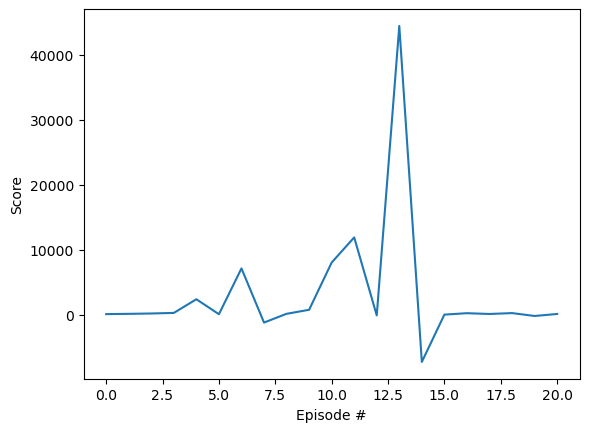

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.savefig('training_scores.png')
plt.show()

1/1 [==============================] - 0s 42ms/step
2
1/1 [==============================] - 0s 14ms/step
1
Buy: $ 190.90
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 19ms/step
0
1/1 [==============================] - 0s 17ms/step
0
1/1 [==============================] - 0s 15ms/step
1
Buy: $ 183.26
1/1 [==============================] - 0s 15ms/step
0
1/1 [==============================] - 0s 14ms/step
2
Sell: $ 184.13 | Profit: -$ 6.77
1/1 [==============================] - 0s 16ms/step
1
Buy: $ 180.13
1/1 [==============================] - 0s 16ms/step
0
1/1 [==============================] - 0s 15ms/step
2
Sell: $ 197.58 | Profit: $ 14.32
1/1 [==============================] - 0s 14ms/step
2
Sell: $ 191.15 | Profit: $ 1

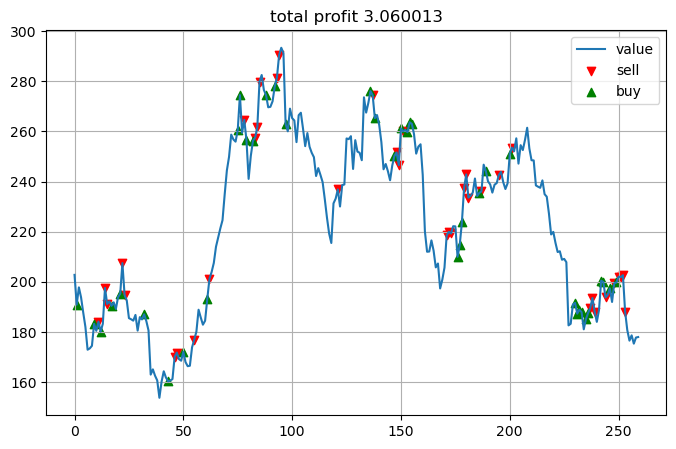

In [19]:
import matplotlib.pyplot as plt

# Run a stock trading simulation using a pre-trained Deep Q-Network (DQN) model.

# Model Loading:
  # Takes a user input for the model name.
  # Loads a pre-trained model based on the provided name.
model_name = input()
model = load_model(model_name)

# Extracts the window size from the input shape of the first layer of the model,
# which indicates how many past time steps (e.g., days of stock prices) the model expects as input.
window_size = model.layers[0].input.shape.as_list()[1]

# Initialize an agent for evaluation (True parameter indicates evaluation mode),
# with the window size derived from the model and the name of the model.
agent = Agent(window_size, True, model_name)

# Initialize data, batch_size, initial state, initial profit, and inventory (similar as training part).
data=list(price_df['Close'][1000:])
data_df = pd.DataFrame(data, columns=['Close'])

l = len(data) - 1
batch_size = 32
state = getState(data, 0, window_size + 1)
total_profit = 0
action_list = []
agent.inventory = []

# Similar work as in the training process, except that there is no model training step:
for t in range(l):
    action = agent.act(state)
    print(action)
    # sit
    next_state = getState(data, t + 1, window_size + 1)
    reward = 0
    if action == 1: # buy
        agent.inventory.append(data[t])
        action_list.append(action)
        print("Buy: " + formatPrice(data[t]))

    elif action == 2 and len(agent.inventory) > 0: # sell
        bought_price = agent.inventory.pop(0)
        reward = max(data[t] - bought_price, 0)
        total_profit += data[t] - bought_price
        action_list.append(action)
        print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(data[t] - bought_price))

    else:
        action_list.append(0)
    
    done = True if t == l - 1 else False
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print("--------------------------------")
        print(ticker + " Total Profit: " + formatPrice(total_profit))
        action_list.append(0)
        data_df['action'] = action_list
        data_df["Close"].plot(figsize=(8, 5), grid=True)
        sell_signals = data_df[data_df['action'] == 2]
        buy_signals = data_df[data_df['action'] == 1]

        plt.scatter(sell_signals.index, sell_signals["Close"], c='r', marker='v', label='Sell')
        plt.scatter(buy_signals.index, buy_signals["Close"], c='g', marker='^', label='Buy')

        plt.legend(['value', 'sell', 'buy'])
        plt.title('total profit %f'%(total_profit))
        plt.savefig('evaluating_graph.png')
        plt.show()

    # Notice that there are several main differences between evaluation process and training process before:
    # 1. Exploitation Only: The agent exclusively uses its learned policy to make decisions, without random exploration.
    # 2. No Model Updates: The agent does not update its model during evaluation. Experiences may still be stored (for review or analysis),
    # but they are not used for training. The focus is on assessing the effectiveness of the current policy.
    # 3. Consistent Policy: Since the model is not being updated, the agent's policy remains consistent throughout the evaluation phase.